In [6]:
import os
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
from pyspark import SparkContext 
from pyspark.sql.types import StringType, StructField, StructType, IntegerType, DecimalType, ArrayType
import pyspark.sql.functions as F
from pyspark import StorageLevel
from pyspark.sql.window import Window


import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


### Uso do Spark

Foi utilizando o Spark para obter maior performance com processamento em memória dos dados de origem


In [7]:
spark = SparkSession.builder.master("local[1]") \
    .appName("SparkByExamples.com") \
    .config("spark.executor.memory","8G") \
    .config("spark.driver.memory","8G") \
    .config("spark.executor.cores","12") \
    .getOrCreate()

23/03/14 19:49:14 WARN Utils: Your hostname, daholive-Dell-G15-5510 resolves to a loopback address: 127.0.1.1; using 192.168.0.114 instead (on interface wlp0s20f3)
23/03/14 19:49:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/14 19:49:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [8]:
relative_path = os.path.abspath('.')

In [9]:
dados_path = relative_path + "/dados/"

In [13]:
csv_list = [dados_path+item for item in os.listdir(dados_path)]
csv_list

['/home/daholive/Documents/10-Projetos/DesafiosRaizen/dados/2011.csv',
 '/home/daholive/Documents/10-Projetos/DesafiosRaizen/dados/2012.csv',
 '/home/daholive/Documents/10-Projetos/DesafiosRaizen/dados/2016.csv',
 '/home/daholive/Documents/10-Projetos/DesafiosRaizen/dados/2017.csv',
 '/home/daholive/Documents/10-Projetos/DesafiosRaizen/dados/2014.csv',
 '/home/daholive/Documents/10-Projetos/DesafiosRaizen/dados/2015.csv',
 '/home/daholive/Documents/10-Projetos/DesafiosRaizen/dados/2013.csv',
 '/home/daholive/Documents/10-Projetos/DesafiosRaizen/dados/2010.csv']

In [14]:
df = spark.read.option("header",True).csv(csv_list)

In [15]:
df = df.persist(StorageLevel.MEMORY_ONLY)

In [16]:
df.printSchema()

root
 |-- time: string (nullable = true)
 |-- ca: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- scp: string (nullable = true)
 |-- station: string (nullable = true)
 |-- linename: string (nullable = true)
 |-- division: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- entries: string (nullable = true)
 |-- exits: string (nullable = true)



## Data Describe

- The readings occur every 4 hours
- The 4-hour observation windows are not the same for all turnstiles
- Some of the turnstiles are counting down, not up. ¯\_(ツ)_/¯
- Each turnstile that’s keeping track of counts is identified by its “subunit channel position” or scp, unique within a control area.
- Each turnstile is in a “control area”, which is the bank of turnstiles associated with a subway exit or exits, unique within a remote unit.
- Each control area is in a “remote unit”. Remote unit generally represents a single station, but some stations and station complexes have several associated remote unit ids.

## Important observation

The most important thing to know is that the entries and exits columns are not counts of people for a given timeframe, they are more like odometer readings. To know how many entries there were at a given observation, you must know the reading from the previous observation and calculate the difference.

## Modification RAW Data

To make life easier, a few modifications to the raw data are made:

- Combine the date and time columns into a proper timestamp named observed_at. This allows us to use the database’s time functions to quickly group by day.
- Concatenate remoteunit, controlarea, scp , and timestamp into id , and enforce uniqueness. This prevents duplicate observations for the same turnstile and timestamp (these exist in the raw data for various reasons)
- Concatenate remoteunit, controlarea, andscp into unit_id , which describes a single turnstile. This is useful for calculating the net entries and exits

One big caveat: We also never allownet_entries or net_exits to be greater than 10,000. Because the turnstile readings are like odometers, they can only count so high. When they roll over, the result is astronomically large net values that need to be thrown out. 10,000 is a reasonable cutoff for excluding these errant calculations, as it represents 2,500 persons per hour passing through a turnstile, or 41 persons per minute.


In [17]:
windowSpecEntries = Window.partitionBy(F.col('unit_id')).orderBy(
    F.col('observed_at')
)

In [18]:
df = df.withColumn(
    'observed_at', F.to_timestamp('time')
).withColumn(
    'id', F.concat_ws('|', 
        F.col('unit'),
        F.col('ca'),
        F.col('scp'),
        F.col('observed_at')
    )
).withColumn(
    'unit_id', F.concat_ws('|', 
        F.col('unit'),
        F.col('ca'),
        F.col('scp')
    )
).withColumn(
    'calc_net_entries',F.col("entries") - F.lag("entries", 1).over(windowSpecEntries)
).withColumn(
    'calc_net_exits',F.col("exits") - F.lag("exits", 1).over(windowSpecEntries)
).withColumn(
    'hours_difference', ((F.date_format(F.col("observed_at"),"d") - F.date_format(F.lag("observed_at", 1).over(windowSpecEntries),"d")) * 24) +
                (F.date_format(F.col("observed_at"),"H") - F.date_format(F.lag("observed_at", 1).over(windowSpecEntries),"H"))
).withColumn(
    'net_entries', F.when(
        (F.abs('calc_net_entries') < 10000) & (F.col('hours_difference') <= 24), F.abs('calc_net_entries')
    ).otherwise(F.lit(0))
).withColumn(
    'net_exits', F.when(
        (F.abs('calc_net_exits') < 10000) & (F.col('hours_difference') <= 24), F.abs('calc_net_exits')
    ).otherwise(F.lit(0))
)

In [19]:
df.printSchema()

root
 |-- time: string (nullable = true)
 |-- ca: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- scp: string (nullable = true)
 |-- station: string (nullable = true)
 |-- linename: string (nullable = true)
 |-- division: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- entries: string (nullable = true)
 |-- exits: string (nullable = true)
 |-- observed_at: timestamp (nullable = true)
 |-- id: string (nullable = false)
 |-- unit_id: string (nullable = false)
 |-- calc_net_entries: double (nullable = true)
 |-- calc_net_exits: double (nullable = true)
 |-- hours_difference: double (nullable = true)
 |-- net_entries: double (nullable = true)
 |-- net_exits: double (nullable = true)



## Daily Counts by individual turnstile

#### Now aggregate into daily counts for each unit_id. Add 2 hours to observed_at for deciding which date it should fall into. (midnight falls to following day, meaning a 4-hour observation period ending at midnight gets counted on the next day, which is bad. With a 2 hour offset, observations through 1:59am will count to the previous day)



In [20]:
df_daily_subunit = df.groupBy(
    F.col('station'),
    F.col('linename'),
    F.col('unit_id'),
    F.date_format(F.date_trunc('day',F.expr("observed_at - INTERVAL 2 HOURS")),'yyyy-MM-dd').alias('date')
).agg(
    F.array_distinct(F.collect_list('unit')).getItem(0).alias('unit'),
    F.sum('net_entries').alias('entries'),
    F.sum('net_exits').alias('exits'),
)

In [21]:
df_daily_subunit.count()

12047689

### CHECKPOINT 1

In [ ]:
(df_daily_subunit
 .repartition(1)
 .write
 .option('mergeSchema', 'true')
 .option('overwriteSchema', 'true')
 .save(relative_path+"/nyc_subway_traffic_data", mode='overwrite')) 

## EXPLORATORY DATA ANALYSIS

In [10]:
# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import pandas as pd
import numpy as np

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports análise e modelagem de séries temporais
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import OneHotEncoder

# Formatando as saídas dos gráficos
plt.style.use('fivethirtyeight')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

In [11]:
dataframe = spark.read.parquet(relative_path+"/nyc_subway_traffic_data")

In [12]:
dataframe = dataframe.persist(StorageLevel.MEMORY_ONLY)

In [13]:
dataframe.count()

12047689

In [14]:
dataframe.printSchema()

root
 |-- station: string (nullable = true)
 |-- linename: string (nullable = true)
 |-- unit_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- entries: double (nullable = true)
 |-- exits: double (nullable = true)



## NEW FEATURES

Creating new features to evaluate data distribution over time

In [15]:
dataframe = dataframe.withColumn(
    'month', F.date_format('date','yyyy-MM')
).withColumn(
    'year', F.year('date')
).withColumn(
    'dayofweek', F.dayofweek('date')
).withColumn(
    'weekofyear', F.weekofyear('date')
).withColumn(
    'traffic', F.col('entries') + F.col('exits')
).filter(
    (F.col('entries')!=0) & (F.col('exits')!=0)
)

In [16]:
dataframe = dataframe.filter(
    F.col('station').isNotNull() & F.col('linename').isNotNull()
)

In [17]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
#df_pandas = dataframe.toPandas()

In [18]:
import pyspark

def spark_shape(self):
    return (self.count(), len(self.columns))
    
pyspark.sql.dataframe.DataFrame.shape = spark_shape

### Sampling method

I decided to use a sampling method that has a 99% confidence level.

In [19]:
# nivel confianca 99%
# z = 2.58
z = 2.58
p = 0.5
e = 0.01
N = dataframe.shape()[0]

In [20]:
amostra = ((z**2)*(p*(1-p))/(e**2))
amostra

16641.0

In [21]:
fraction = amostra / N
fraction

0.001580992294265789

In [22]:
df_sample = dataframe.sample(fraction,43)

In [23]:
df_sample.count()

16925

## Exploratory Analysis with Pandas Dataframe

In [24]:
df_pandas = df_sample.toPandas()

In [25]:
df_pandas

station linename             unit_id        date  unit  entries   exits    month  year  dayofweek  weekofyear  traffic
0               110 ST        6  R181|R253|00-00-01  2010-07-09  R181  1946.00 1779.00  2010-07  2010          6          27  3725.00
1               110 ST        6  R181|R253|00-00-01  2012-07-20  R181   444.00 2118.00  2012-07  2012          6          29  2562.00
2               110 ST        6  R181|R253|00-00-01  2012-12-11  R181  1280.00 1983.00  2012-12  2012          3          50  3263.00
3               110 ST        6  R181|R253|00-00-01  2015-01-14  R181  1325.00 1985.00  2015-01  2015          4           3  3310.00
4               110 ST        6  R181|R253|00-00-01  2016-05-09  R181  1888.00 2149.00  2016-05  2016          2          19  4037.00
...                ...      ...                 ...         ...   ...      ...     ...      ...   ...        ...         ...      ...
16920    STILLWELL AVE     DFNQ  R151|G001|00-03-01  2011-06-09  R151  1879.00 1065.00  2011-06  2011          5          23  2944.00
16921    STILLWELL AVE     DFNQ  R151|G001|00-03-01  2012-04-13  R151   561.00  318.00  2012-04  2012          6          15   879.00
16922    STILLWELL AVE     DFNQ  R151|G001|00-03-01  2013-02-23  R151   142.00   67.00  2013-02  2013          7           8   209.00
16923  UNION TPK-KEW G       EF  R158|N336|00-00-04  2012-04-10  R158  4194.00  373.00  2012-04  2012          3          15  4567.00
16924  UNION TPK-KEW G       EF  R158|N336|00-00-04  2013-05-14  R158  4565.00  478.00  2013-05  2013          3          20  5043.00

[16925 rows x 12 columns]

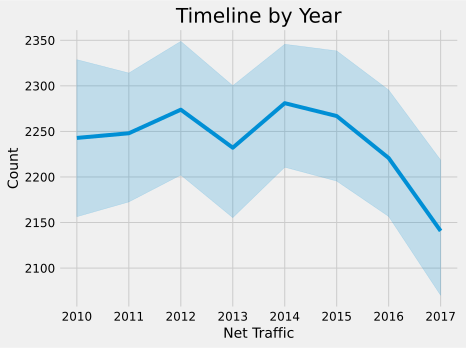

In [23]:
# Rider count per year

sns.lineplot(x = 'year', y = 'traffic', data = df_pandas)
plt.ticklabel_format(axis='x', style='plain');
plt.title('Timeline by Year');
plt.xlabel('Net Traffic');
plt.ylabel('Count');
plt.xticks(rotation=0);

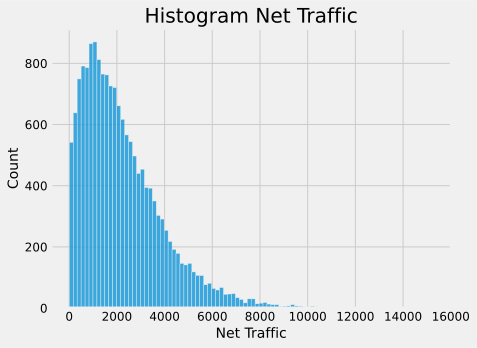

In [24]:
# Histogram of Riders 

sns.histplot(x = 'traffic', data = df_pandas)
plt.ticklabel_format(axis='x', style='plain');
plt.title('Histogram Net Traffic');
plt.xlabel('Net Traffic');
plt.ylabel('Count');
plt.xticks(rotation=0);

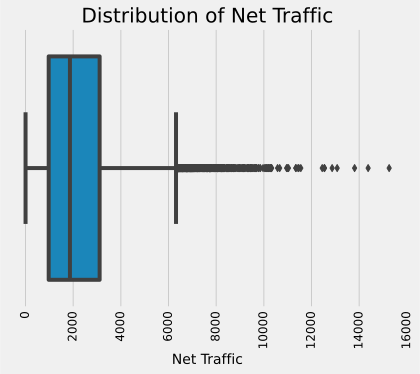

In [25]:
# Boxplot of Riders 

sns.boxplot(x = 'traffic', data = df_pandas)
plt.ticklabel_format(axis='x', style='plain');
plt.title('Distribution of Net Traffic');
plt.xlabel('Net Traffic');
plt.xticks(rotation=90);

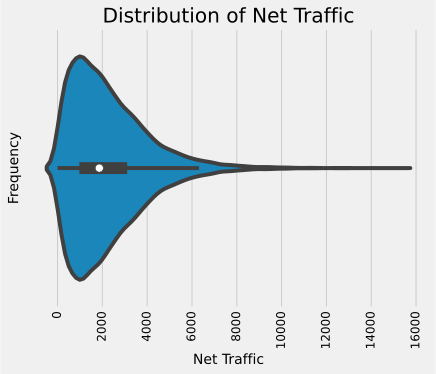

In [26]:
sns.violinplot(x=df_pandas.traffic);
plt.ticklabel_format(axis='x', style='plain');
plt.title('Distribution of Net Traffic');
plt.xlabel('Net Traffic');
plt.ylabel('Frequency');
plt.xticks(rotation=90);
plt.savefig('violin_before.png', bbox_inches='tight');

## Timelapse by week of the year

The graph below shows that peak traffic exceeds 800,000 passengers in the middle of the year.

In [27]:
weekly_timelapse_df = df_pandas.groupby(['weekofyear'])[['traffic']].sum().reset_index().copy()
weekly_timelapse_df['pct_change'] = weekly_timelapse_df.traffic.pct_change()
weekly_timelapse_df['pct_change'].iloc[0] = 0
weekly_timelapse_df['pct_total'] = weekly_timelapse_df['traffic'].apply(lambda x: x / weekly_timelapse_df.traffic.sum())

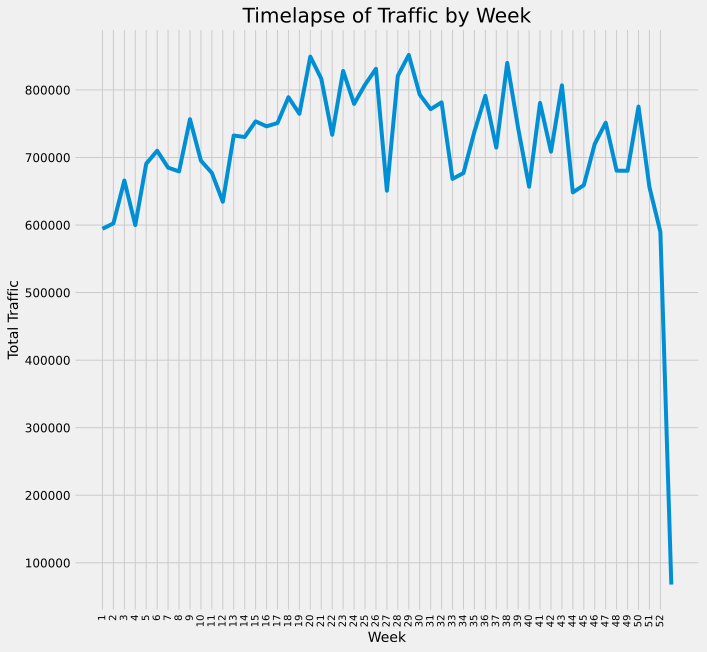

In [28]:
plt.figure(figsize=(10,10))
sns.lineplot(data=weekly_timelapse_df, x='weekofyear', y='traffic');
plt.title('Timelapse of Traffic by Week');
plt.xlabel('Week');
plt.ylabel('Total Traffic');
plt.ticklabel_format(axis='y', style='plain');
plt.xticks(np.linspace(1,52,52), rotation=90, fontsize=10);


## Timelapse by day on year

The graph below shows that peak traffic exceeds 800,000 passengers in the middle of the year.

The overall mean is at 2221 with a standard deviation of 890. The variance is quite high with a value above 790k

In [29]:
daily_timelapse_df = df_pandas.groupby(['date'])[['traffic']].mean().reset_index()
daily_timelapse_df['pct_change'] = daily_timelapse_df.traffic.pct_change()

In [30]:
np.mean(daily_timelapse_df.traffic)

2238.4030505974983

In [31]:
np.std(daily_timelapse_df.traffic)

902.0555125857919

In [32]:
np.var(daily_timelapse_df.traffic, axis=0)

813704.1477864158

In [33]:
plt.figure(figsize=(12,8))
sns.lineplot(data=daily_timelapse_df, x='date', y='traffic');
plt.title('Timelapse of Traffic by Day')
plt.xlabel('Date')
plt.ylabel('Average Traffic')
plt.xticks(rotation=90);
plt.savefig('trafficbyday.png', bbox_inches='tight');

## Average monthly traffic

The graph below shows that peak traffic exceeds 800,000 passengers in the middle of the year.

The overall mean is at 2221 with a standard deviation of 890. The variance is quite high with a value above 790k

In [34]:
monthly_df = df_pandas.groupby('month')[['traffic']].sum().reset_index().copy()

In [35]:
monthly_df['pct_change'] = monthly_df.traffic.pct_change()
monthly_df['pct_change'].iloc[0] = 0
monthly_df['pct_total'] = monthly_df['traffic'].apply(lambda x: x / monthly_df.traffic.sum())

In [36]:
monthly_timelapse = df_pandas.groupby('month')[['traffic']].mean().reset_index().copy()

In [37]:
np.mean(monthly_timelapse)

traffic   2246.89
dtype: float64

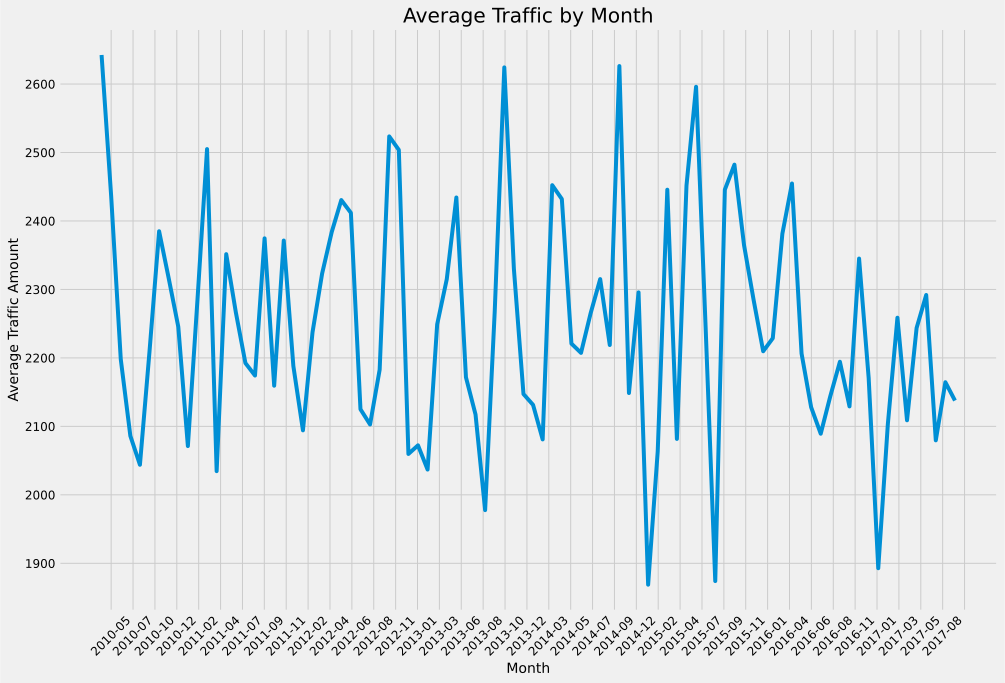

In [38]:
plt.figure(figsize=(15,10))
plt.plot(monthly_timelapse.month, monthly_timelapse.traffic);
plt.xlabel('Month')
plt.xticks(np.linspace(1,90,40));
plt.xlabel('Month');
plt.xticks(rotation=45);
plt.ylabel('Average Traffic Amount');
plt.title('Average Traffic by Month');
plt.savefig('avgtrafficbymonth.png', bbox_inches='tight')

In [39]:
dayofweek_df = df_pandas.groupby('dayofweek')[['traffic']].sum()
dayofweek_df['pct_change'] = dayofweek_df.traffic.pct_change()
dayofweek_df['pct_change'].iloc[0] = ((dayofweek_df.traffic.iloc[0] - dayofweek_df.traffic.iloc[6]) / dayofweek_df.traffic.iloc[6])
dayofweek_df['pct_total'] = dayofweek_df['traffic'].apply(lambda x: x / dayofweek_df.traffic.sum())

Text(0.5, 1.0, 'Total Riders by Day of Week')

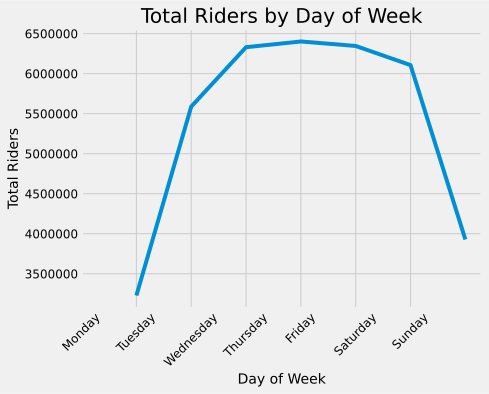

In [40]:
plt.plot(dayofweek_df.index, dayofweek_df.traffic);
plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45);
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Day of Week')
plt.ylabel('Total Riders')
plt.title('Total Riders by Day of Week')


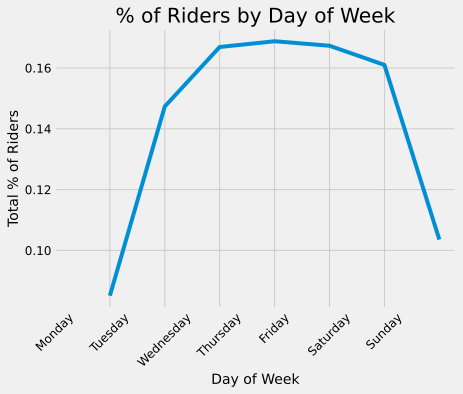

In [41]:
plt.plot(dayofweek_df.index, dayofweek_df.pct_total);
plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45);
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Total % of Riders');
plt.xlabel('Day of Week');
plt.title('% of Riders by Day of Week');
plt.savefig('pct_riders_dayofweek.png', bbox_inches='tight');

In [26]:
df_rnn = df_pandas[['station','linename','unit_id','dayofweek','weekofyear','traffic']]

### TRATAMENTO DOS DADOS

In [30]:
X_cat = df_rnn[['station','linename','unit_id','dayofweek','weekofyear']]

In [28]:
from sklearn.preprocessing import OneHotEncoder

In [31]:
onehotencoder = OneHotEncoder()

In [32]:
X_cat = onehotencoder.fit_transform(X_cat).toarray()

In [34]:
X_cat.shape

(16925, 4915)

In [35]:
X_cat = pd.DataFrame(X_cat)

In [36]:
X_cat.head()

0     1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    35    36    37    38    39    40    41    42    43    44    45    46    47    48    49    50    51    52    53    54    55    56    57    58    59    60    61    62    63    64    65    66    67    68    69    70    71    72    73    74    75    76    77    78    79    80    81    82    83    84    85    86    87    88    89    90    91    92    93    94    95    96    97    98    99    100   101   102   103   104   105   106   107   108   109   110   111   112   113   114   115   116   117   118   119   120   121   122   123   124   125   126   127   128   129   130   131   132   133   134   135   136   137   138   139   140   141   142   143   144   145   146   147   148   149   150   151   152   153   154   155   156   157   158   159   160   161   162   163   164   165   166   167   168   169   170   171   172   173   174   175   176   177   178   179   180   181   182   183   184   185   186   187   188   189   190   191   192   193   194   195   196   197   198   199   200   201   202   203   204   205   206   207   208   209   210   211   212   213   214   215   216   217   218   219   220   221   222   223   224   225   226   227   228   229   230   231   232   233   234   235   236   237   238   239   240   241   242   243   244   245   246   247   248   249   ...  4665  4666  4667  4668  4669  4670  4671  4672  4673  4674  4675  4676  4677  4678  4679  4680  4681  4682  4683  4684  4685  4686  4687  4688  4689  4690  4691  4692  4693  4694  4695  4696  4697  4698  4699  4700  4701  4702  4703  4704  4705  4706  4707  4708  4709  4710  4711  4712  4713  4714  4715  4716  4717  4718  4719  4720  4721  4722  4723  4724  4725  4726  4727  4728  4729  4730  4731  4732  4733  4734  4735  4736  4737  4738  4739  4740  4741  4742  4743  4744  4745  4746  4747  4748  4749  4750  4751  4752  4753  4754  4755  4756  4757  4758  4759  4760  4761  4762  4763  4764  4765  4766  4767  4768  4769  4770  4771  4772  4773  4774  4775  4776  4777  4778  4779  4780  4781  4782  4783  4784  4785  4786  4787  4788  4789  4790  4791  4792  4793  4794  4795  4796  4797  4798  4799  4800  4801  4802  4803  4804  4805  4806  4807  4808  4809  4810  4811  4812  4813  4814  4815  4816  4817  4818  4819  4820  4821  4822  4823  4824  4825  4826  4827  4828  4829  4830  4831  4832  4833  4834  4835  4836  4837  4838  4839  4840  4841  4842  4843  4844  4845  4846  4847  4848  4849  4850  4851  4852  4853  4854  4855  4856  4857  4858  4859  4860  4861  4862  4863  4864  4865  4866  4867  4868  4869  4870  4871  4872  4873  4874  4875  4876  4877  4878  4879  4880  4881  4882  4883  4884  4885  4886  4887  4888  4889  4890  4891  4892  4893  4894  4895  4896  4897  4898  4899  4900  4901  4902  4903  4904  4905  4906  4907  4908  4909  4910  4911  4912  4913  4914
0  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.0

In [38]:
X_numerical = df_rnn[['traffic']]

In [39]:
X_all = pd.concat([X_cat, X_numerical], axis = 1)

In [40]:
X_all.head()

0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80   81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96   97   98   99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  198  199  200  201  202  203  204  205  206  207  208  209  210  211  212  213  214  215  216  217  218  219  220  221  222  223  224  225  226  227  228  229  230  231  232  233  234  235  236  237  238  239  240  241  242  243  244  245  246  247  248  249  ...  4666  4667  4668  4669  4670  4671  4672  4673  4674  4675  4676  4677  4678  4679  4680  4681  4682  4683  4684  4685  4686  4687  4688  4689  4690  4691  4692  4693  4694  4695  4696  4697  4698  4699  4700  4701  4702  4703  4704  4705  4706  4707  4708  4709  4710  4711  4712  4713  4714  4715  4716  4717  4718  4719  4720  4721  4722  4723  4724  4725  4726  4727  4728  4729  4730  4731  4732  4733  4734  4735  4736  4737  4738  4739  4740  4741  4742  4743  4744  4745  4746  4747  4748  4749  4750  4751  4752  4753  4754  4755  4756  4757  4758  4759  4760  4761  4762  4763  4764  4765  4766  4767  4768  4769  4770  4771  4772  4773  4774  4775  4776  4777  4778  4779  4780  4781  4782  4783  4784  4785  4786  4787  4788  4789  4790  4791  4792  4793  4794  4795  4796  4797  4798  4799  4800  4801  4802  4803  4804  4805  4806  4807  4808  4809  4810  4811  4812  4813  4814  4815  4816  4817  4818  4819  4820  4821  4822  4823  4824  4825  4826  4827  4828  4829  4830  4831  4832  4833  4834  4835  4836  4837  4838  4839  4840  4841  4842  4843  4844  4845  4846  4847  4848  4849  4850  4851  4852  4853  4854  4855  4856  4857  4858  4859  4860  4861  4862  4863  4864  4865  4866  4867  4868  4869  4870  4871  4872  4873  4874  4875  4876  4877  4878  4879  4880  4881  4882  4883  4884  4885  4886  4887  4888  4889  4890  4891  4892  4893  4894  4895  4896  4897  4898  4899  4900  4901  4902  4903  4904  4905  4906  4907  4908  4909  4910  4911  4912  4913  4914  traffic
0 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.0

In [41]:
X = X_all.iloc[:, :-1].values

In [42]:
y = X_all.iloc[:, -1:].values

In [43]:
X.shape

(16925, 4915)

In [44]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y = scaler.fit_transform(y)

In [45]:
y

array([[0.24403513],
       [0.16780283],
       [0.21375197],
       ...,
       [0.01356843],
       [0.29922653],
       [0.33042737]])

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [47]:
X_train.shape

(13540, 4915)

In [48]:
X_test.shape

(3385, 4915)

# Construção e treinamento do modelo

In [53]:
import tensorflow as tf

2023-03-14 20:45:11.836775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 20:45:11.975575: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-14 20:45:11.975594: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-14 20:45:12.505684: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [58]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units = 100, activation='relu', input_shape=(4915,)))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='linear'))

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               491600    
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 511,901
Trainable params: 511,901
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.compile(optimizer='Adam', loss='mean_squared_error')

In [61]:
epochs_hist = model.fit(X_train, y_train, epochs = 25, batch_size = 50, validation_split=0.2)

Epoch 1/25
217/217 [==============================] - 2s 6ms/step - loss: 0.0079 - val_loss: 0.0055
Epoch 2/25
217/217 [==============================] - 1s 5ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 3/25
217/217 [==============================] - 1s 5ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 4/25
217/217 [==============================] - 1s 5ms/step - loss: 9.0313e-04 - val_loss: 0.0033
Epoch 5/25
217/217 [==============================] - 1s 5ms/step - loss: 6.4419e-04 - val_loss: 0.0032
Epoch 6/25
217/217 [==============================] - 1s 6ms/step - loss: 5.1943e-04 - val_loss: 0.0033
Epoch 7/25
217/217 [==============================] - 1s 5ms/step - loss: 4.4079e-04 - val_loss: 0.0031
Epoch 8/25
217/217 [==============================] - 1s 5ms/step - loss: 3.7955e-04 - val_loss: 0.0032
Epoch 9/25
217/217 [==============================] - 1s 5ms/step - loss: 3.2511e-04 - val_loss: 0.0032
Epoch 10/25
217/217 [==============================] - 1s 5ms/step - loss: 2

# Avaliação do modelo 

In [62]:
epochs_hist.history.keys()

dict_keys(['loss', 'val_loss'])

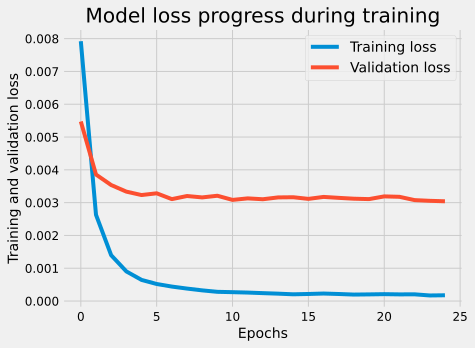

In [63]:
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title('Model loss progress during training')
plt.xlabel('Epochs')
plt.ylabel('Training and validation loss')
plt.legend(['Training loss', 'Validation loss']);

In [64]:
y_predict = model.predict(X_test)

106/106 [==============================] - 0s 1ms/step


In [65]:
y_predict

array([[0.02674336],
       [0.12675108],
       [0.08404922],
       ...,
       [0.17615601],
       [0.3355769 ],
       [0.14487134]], dtype=float32)

Text(0, 0.5, 'True values')

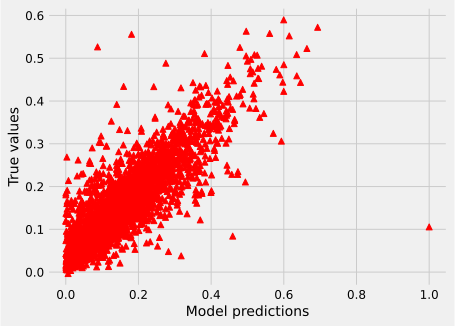

In [66]:
plt.plot(y_test, y_predict, "^", color = 'r')
plt.xlabel('Model predictions')
plt.ylabel('True values')

In [67]:
y_predict_orig = scaler.inverse_transform(y_predict)
y_test_orig = scaler.inverse_transform(y_test)

Text(0, 0.5, 'True values')

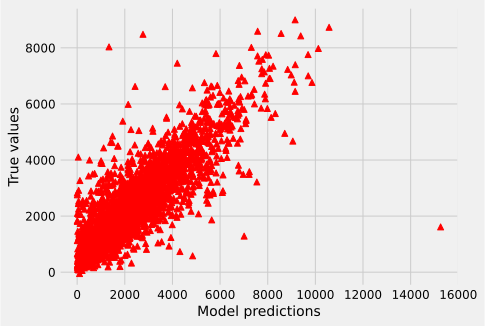

In [68]:
plt.plot(y_test_orig, y_predict_orig, "^", color = 'r')
plt.xlabel('Model predictions')
plt.ylabel('True values')

In [69]:
k = X_test.shape[1]
k

4915

In [70]:
n = len(X_test)
n

3385

In [71]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

In [72]:
mae = mean_absolute_error(y_test_orig, y_predict_orig)
mse = mean_squared_error(y_test_orig, y_predict_orig)
rmse = sqrt(mse)
r2 = r2_score(y_test_orig, y_predict_orig)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

In [73]:
print("MAE: ", mae, "\nMSE: ", mse, "\nRMSE: ", rmse, "\nR2: ", r2, "\nADJ R2: ", adj_r2)

MAE:  566.8618094586551 
MSE:  738663.7752499923 
RMSE:  859.4555109195544 
R2:  0.7354780285548965 
ADJ R2:  1.5846782177467211
